In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from my_load import CPU_Unpickler
import pickle

# Load dataset
#ds_path = '../output/00024/dataset.pkl'
ds_path = '../output/FCC-organs/true_positive_aggregation/00004/dataset.pkl'  # <-- select patient here
with open(ds_path, 'rb') as f:
    ds = CPU_Unpickler(f).load()
    if isinstance(ds, DataLoader):
        ds = ds.dataset

# Extract tensors
X, y, w = (t.cpu() for t in ds.tensors)  # features, targets, sample weights
X_np, y_np, w_np = X.numpy(), y.numpy().ravel(), w.numpy().ravel()

print(f"Dataset shape: X={X_np.shape}, y={y_np.shape}, w={w_np.shape}")
print(f"Output range: [{y_np.min():.6f}, {y_np.max():.6f}]")
print(f"Weight range: [{w_np.min():.6f}, {w_np.max():.6f}]")

Dataset shape: X=(2000, 428), y=(2000,), w=(2000,)
Output range: [0.000000, 0.008726]
Weight range: [1.000000, 1000000.000000]


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit weighted linear regression
linreg = LinearRegression()
linreg.fit(X_np, y_np, sample_weight=w_np)

# Predictions
y_pred = linreg.predict(X_np)

# Metrics
mse = mean_squared_error(y_np, y_pred, sample_weight=w_np)
r2 = r2_score(y_np, y_pred, sample_weight=w_np)

print(f"Linear Regression - MSE: {mse:.6f}, R²: {r2:.6f}")
print("Learned weights:", linreg.coef_)
print("Intercept:", linreg.intercept_)

Linear Regression - MSE: 0.000000, R²: 0.998817
Learned weights: [ 2.15509368e-04 -1.94599765e-04 -4.27437335e-05 -2.55779596e-05
 -5.28717879e-04 -6.44975633e-04 -7.18841853e-04  4.89236903e-04
  6.98485528e-04  2.23243551e-04 -5.71918208e-05 -2.40129244e-04
 -2.39578629e-04 -5.13359264e-05  6.04288187e-04  4.17423398e-05
  3.69775022e-04  7.95083470e-05 -1.05804810e-03  1.48980180e-04
 -3.11654876e-05  4.69640887e-04  1.16368115e-04 -2.94439960e-04
 -3.05781432e-04 -4.56025708e-04  9.85990773e-05  4.20807279e-04
  5.02734561e-04 -7.53335189e-06 -1.23618986e-04 -1.97919784e-04
  5.01531875e-04 -5.00105962e-04 -1.43502490e-04  5.39290020e-04
  3.87811509e-04  3.92043468e-04 -9.57065204e-05 -1.52310968e-04
  3.95314419e-04  7.91993079e-05  5.95406163e-07 -3.79544625e-04
 -1.00553816e-03 -7.98421679e-05 -5.55531587e-04 -8.43781338e-04
 -5.30536054e-05  4.30352869e-04 -4.50052903e-04 -6.69072091e-04
  6.36114448e-04  2.10934631e-05 -1.30796281e-04 -3.16925842e-04
  6.71953370e-04  6.49138

In [3]:
import statsmodels.api as sm

# Add constant for intercept
X_sm = sm.add_constant(X_np)

# Weighted Least Squares (WLS) to include sample weights
model = sm.WLS(y_np, X_sm, weights=w_np)
results = model.fit()

print(results.summary())  # p-values, confidence intervals, and R²

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3099.
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:23:41   Log-Likelihood:                 7876.1
No. Observations:                2000   AIC:                        -1.489e+04
Df Residuals:                    1571   BIC:                        -1.249e+04
Df Model:                         428                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.111e-07   5.36e-06     -0.151      0.8

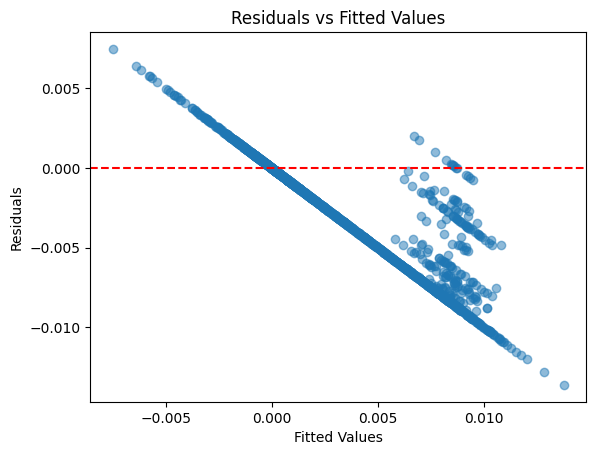

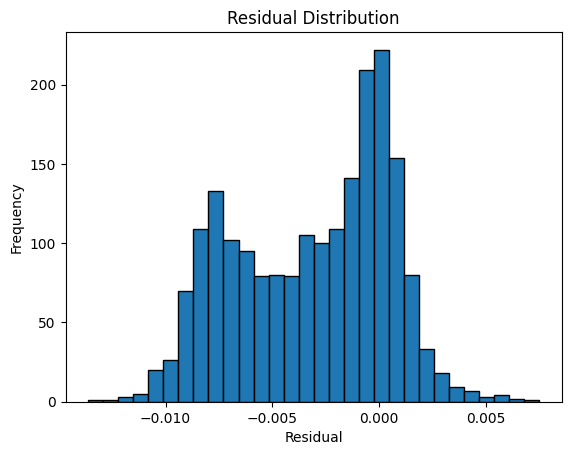

Shapiro-Wilk test: statistic=0.9575, p-value=0.0000
Residuals deviate from normality.


In [4]:
import matplotlib.pyplot as plt

residuals = y_np - y_pred

# Residuals vs Fitted
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Normality test of residuals
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p:.4f}")
if p > 0.05:
    print("Residuals look normally distributed.")
else:
    print("Residuals deviate from normality.")

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for i in range(X_np.shape[1]):
    vif = variance_inflation_factor(X_np, i)
    vif_data.append((f"Feature {i}", vif))

print("Variance Inflation Factors:")
for name, value in vif_data:
    print(f"{name}: {value:.2f}")

Variance Inflation Factors:
Feature 0: 12.61
Feature 1: 12.07
Feature 2: 11.53
Feature 3: 12.51
Feature 4: 12.27
Feature 5: 12.70
Feature 6: 12.14
Feature 7: 10.68
Feature 8: 11.82
Feature 9: 11.83
Feature 10: 12.61
Feature 11: 12.38
Feature 12: 11.83
Feature 13: 11.53
Feature 14: 13.11
Feature 15: 11.84
Feature 16: 12.58
Feature 17: 10.71
Feature 18: 13.55
Feature 19: 11.53
Feature 20: 12.14
Feature 21: 10.66
Feature 22: 12.04
Feature 23: 12.25
Feature 24: 12.32
Feature 25: 13.71
Feature 26: 12.24
Feature 27: 12.01
Feature 28: 12.73
Feature 29: 11.41
Feature 30: 13.36
Feature 31: 13.85
Feature 32: 12.53
Feature 33: 12.35
Feature 34: 12.30
Feature 35: 12.02
Feature 36: 13.59
Feature 37: 11.97
Feature 38: 12.03
Feature 39: 11.85
Feature 40: 12.26
Feature 41: 11.46
Feature 42: 12.12
Feature 43: 14.22
Feature 44: 12.12
Feature 45: 12.31
Feature 46: 12.88
Feature 47: 10.88
Feature 48: 11.63
Feature 49: 12.84
Feature 50: 13.04
Feature 51: 12.36
Feature 52: 12.02
Feature 53: 12.14
Feature 54

In [6]:
from sklearn.linear_model import LassoCV

# Lasso with cross-validation
lasso = LassoCV(cv=5)
lasso.fit(X_np, y_np, sample_weight=w_np)

print("Lasso selected weights:", lasso.coef_)
print("Intercept:", lasso.intercept_)
print(f"Lasso R²: {lasso.score(X_np, y_np):.6f}")

/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e-07, tolerance: 2.762e-07
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.789e-07, tolerance: 2.762e-07
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing re

Lasso selected weights: [6.6921726e-04 3.3055785e-05 1.1254933e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0419848e-05 6.2351719e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9865272e-05
 0.0000000e+00 2.1945958e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 6.4277657e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e

In [7]:
import pandas as pd
from IPython.display import display

# Parametri scelti da Lasso
lasso_selected = (lasso.coef_ != 0)

# Tabella regressione lineare
conf_int = results.conf_int()
coef_summary = pd.DataFrame({
    "Feature": [f"X{i}" for i in range(X_np.shape[1])],
    "OLS Coefficient": results.params[1:],  # skip intercept
    "p-value": results.pvalues[1:],
    "Conf. Int. Low": conf_int[1:, 0],
    "Conf. Int. High": conf_int[1:, 1],
    "Lasso Selected": lasso_selected,
})

# Colonna significatività statistica
coef_summary["Significativo (OLS)"] = coef_summary["p-value"] < 0.05

# Identificazione top 10 per valore assoluto dei coefficienti OLS
top_10_abs = coef_summary["OLS Coefficient"].abs().nlargest(10).index
coef_summary["Top 10 |OLS|"] = coef_summary.index.isin(top_10_abs)

# Funzione di evidenziazione
def highlight(val):
    return 'background-color: lightgreen' if val else ''

def highlight_top(val):
    return 'background-color: lightblue' if val else ''

# Applicazione evidenziazione multipla
styled = (coef_summary.style
          .map(highlight, subset=["Significativo (OLS)", "Lasso Selected"])
          .map(highlight_top, subset=["Top 10 |OLS|"]))

display(styled)

,Feature,OLS Coefficient,p-value,Conf. Int. Low,Conf. Int. High,Lasso Selected,Significativo (OLS),Top 10 |OLS|
0,X0,0.000220,0.718732,-0.000976,0.001415,True,False,False
1,X1,-0.000204,0.728470,-0.001359,0.000950,True,False,False
2,X2,-0.000050,0.931350,-0.001189,0.001089,True,False,False
3,X3,-0.000025,0.966472,-0.001207,0.001156,False,False,False
4,X4,-0.000532,0.369989,-0.001697,0.000632,False,False,False
5,X5,-0.000645,0.284547,-0.001826,0.000537,False,False,False
6,X6,-0.000718,0.222273,-0.001871,0.000435,False,False,False
7,X7,0.000491,0.378170,-0.000602,0.001584,True,False,False
8,X8,0.000695,0.237211,-0.000458,0.001849,True,False,False
9,X9,0.000225,0.700179,-0.000920,0.001369,False,False,False


In [8]:
# create an util to visualize a weight tensor showing the idx, value pairs
def visualize_weights(weights: torch.Tensor):
    length = weights.shape[0]
    idxs = torch.arange(length)

    print("torch.Tensor: ", [(f"{idx.item()}: {weight.item():.2e}") for idx, weight in zip(idxs, weights)])

In [9]:
 # Fit model with first n samples
surrogate = Lasso(alpha=0.0003, max_iter=10000)
X_batch, y_batch, w_batch = next(iter(DataLoader(ds, batch_size=n_samples)))
surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())

# Get coefficients
phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
phi0 = surrogate.intercept_  # intercept
beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

print(f"Intercept (phi0): {phi0:.6f}")
print(f"Coefficients (phis): {visualize_weights(phis)}, shape={phis.shape}")

NameError: name 'Lasso' is not defined

In [ ]:
# sort features by mean value of y for each feature where X[:, i] != 0
mean_y = torch.zeros(n_features)
for i in range(n_features):
    mean_y[i] = y[X[:, i] != 0].mean() if (X[:, i] != 0).any() else -100000.0

sorted_indices_mean_y = torch.argsort(mean_y, descending=True)
print(f"Sorted indices by mean y: {sorted_indices_mean_y.tolist()}")

Sorted indices by mean y: [82, 57, 81, 77, 31, 111, 49, 135, 37, 116, 78, 3, 123, 44, 98, 8, 118, 54, 96, 55, 136, 21, 106, 143, 61, 59, 119, 39, 115, 84, 99, 83, 6, 7, 25, 125, 69, 141, 74, 88, 139, 40, 52, 16, 131, 101, 62, 13, 102, 87, 107, 138, 53, 10, 29, 80, 65, 1, 48, 64, 142, 4, 73, 24, 113, 85, 109, 76, 72, 56, 132, 70, 46, 35, 36, 58, 14, 20, 47, 75, 140, 95, 124, 89, 17, 127, 38, 128, 93, 105, 104, 23, 79, 103, 108, 42, 60, 129, 45, 114, 71, 0, 97, 94, 19, 68, 32, 133, 11, 134, 12, 110, 43, 51, 86, 92, 2, 50, 91, 27, 126, 5, 33, 22, 120, 26, 122, 34, 28, 41, 15, 30, 9, 137, 18, 130, 63, 66, 90, 112, 117, 121, 100, 67]


### first indices belong to the assumed most relevant supervoxels

In [ ]:
# sort features by their coefficients
sorted_indices_coefs = torch.argsort(phis.abs(), descending=True)
print(f"Sorted indices by absolute value of coefficients: {sorted_indices_coefs.tolist()}")

Sorted indices by absolute value of coefficients: [82, 57, 81, 77, 54, 13, 37, 31, 44, 21, 61, 55, 49, 16, 25, 14, 58, 24, 62, 39, 11, 23, 36, 19, 20, 35, 52, 48, 12, 53, 15, 22, 72, 143, 34, 32, 30, 29, 38, 28, 40, 41, 42, 43, 27, 45, 46, 47, 26, 18, 50, 51, 17, 10, 9, 8, 56, 7, 6, 59, 60, 5, 4, 63, 64, 65, 66, 67, 68, 69, 70, 71, 0, 73, 74, 75, 76, 3, 78, 79, 80, 2, 1, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 33]


Feature 82 (mean y=0.005121) is ranked 1 in the coefficients position_in_coefs_ranking
Feature 57 (mean y=0.005037) is ranked 2 in the coefficients position_in_coefs_ranking
Feature 81 (mean y=0.005026) is ranked 3 in the coefficients position_in_coefs_ranking
Feature 77 (mean y=0.004932) is ranked 4 in the coefficients position_in_coefs_ranking
Feature 31 (mean y=0.004920) is ranked 8 in the coefficients position_in_coefs_ranking
Feature 111 (mean y=0.004918) is ranked 112 in the coefficients position_in_coefs_ranking
Feature 49 (mean y=0.004911) is ranked 13 in the coefficients position_in_coefs_ranking
Feature 135 (mean y=0.004910) is ranked 136 in the coefficients position_in_coefs_ranking
Feature 37 (mean y=0.004900) is ranked 7 in the coefficients position_in_coefs_ranking
Feature 116 (mean y=0.004897) is ranked 117 in the coefficients position_in_coefs_ranking


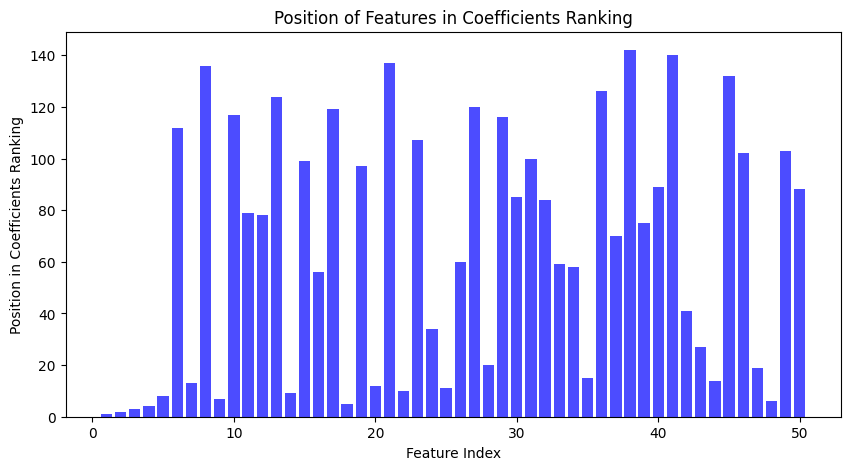

In [ ]:
# draw the position of the highest ranked features according to the mean value of y, in the order of the coefficients
n_best = 10
for i in range(n_best):
    idx = sorted_indices_mean_y[i].item()
    position_in_coefs_ranking = (sorted_indices_coefs == idx).nonzero(as_tuple=True)[0].item()
    print(f"Feature {idx} (mean y={mean_y[idx].item():.6f}) is ranked {position_in_coefs_ranking + 1} in the coefficients position_in_coefs_ranking")

plot_first = 50
idx = sorted_indices_mean_y[:plot_first].numpy()
positions_in_coefs_ranking = [sorted_indices_coefs.tolist().index(i) + 1 for i in idx]
plt.figure(figsize=(10, 5))
plt.bar(range(1, plot_first+1), positions_in_coefs_ranking, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Position in Coefficients Ranking')
plt.title('Position of Features in Coefficients Ranking')
plt.show()